In [244]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

/kaggle/input/car-child-seat-sales-b1/sample_submission.csv
/kaggle/input/car-child-seat-sales-b1/train.csv
/kaggle/input/car-child-seat-sales-b1/test.csv


In [245]:
train_data = pd.read_csv('/kaggle/input/car-child-seat-sales-b1/train.csv')
train_data

,ID,totalSales,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US
0,1,6.01,131,29,11,335,127,Bad,33,12,Yes,Yes
1,2,6.50,148,51,16,148,150,Medium,58,17,No,Yes
2,3,7.70,118,71,12,44,89,Medium,67,18,No,Yes
3,4,7.78,86,54,0,497,64,Bad,33,12,Yes,No
4,5,11.82,113,66,16,322,74,Good,76,15,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,9.70,138,61,12,156,120,Medium,25,14,Yes,Yes
345,346,5.35,130,58,19,366,139,Bad,33,16,Yes,Yes
346,347,11.70,144,69,11,131,104,Medium,47,11,Yes,Yes
347,348,8.73,129,76,16,58,121,Medium,69,12,Yes,Yes


In [246]:
train_data.columns

Index(['ID', 'totalSales', 'CompetitorPrice', 'Income', 'Advertising',
       'Population', 'Price', 'Location', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [247]:
# Feature Engineering
train_data['IncomePerPopulation'] = train_data['Income'] / train_data['Population']
train_data['AdvertisingPerPopulation'] = train_data['Advertising'] / train_data['Population']

In [248]:
# Create the Category target variable based on Sales
category = []
sales = train_data.iloc[:, 1]

for sale in sales:
    if sale <= 5:
        category.append(1)
    elif sale <= 10:
        category.append(2)
    else:
        category.append(3)

train_data['Category'] = category

In [249]:
# Remove the original columns
train_data.drop([train_data.columns[0], train_data.columns[1]], axis=1, inplace=True)

In [250]:
train_data.head(10)

,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US,IncomePerPopulation,AdvertisingPerPopulation,Category
0,131,29,11,335,127,Bad,33,12,Yes,Yes,0.086567,0.032836,2
1,148,51,16,148,150,Medium,58,17,No,Yes,0.344595,0.108108,2
2,118,71,12,44,89,Medium,67,18,No,Yes,1.613636,0.272727,2
3,86,54,0,497,64,Bad,33,12,Yes,No,0.108652,0.000000,2
4,113,66,16,322,74,Good,76,15,Yes,Yes,0.204969,0.049689,3
5,122,35,2,393,136,Medium,62,18,Yes,No,0.089059,0.005089,1
6,118,70,0,106,89,Bad,39,17,Yes,No,0.660377,0.000000,2
7,107,119,11,210,132,Medium,53,11,Yes,Yes,0.566667,0.052381,2
8,118,32,0,284,110,Good,63,13,Yes,No,0.112676,0.000000,2
9,126,80,19,436,126,Medium,52,10,Yes,Yes,0.183486,0.043578,2


In [251]:
y = train_data['Category']

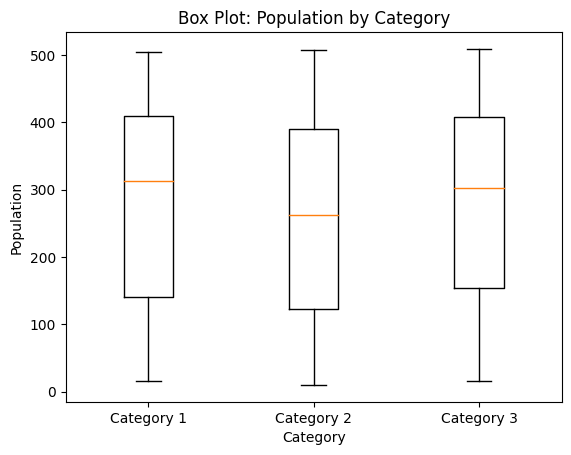

In [252]:
plt.boxplot([train_data[train_data['Category'] == 1]['Population'],
             train_data[train_data['Category'] == 2]['Population'],
             train_data[train_data['Category'] == 3]['Population']])
plt.xlabel('Category')
plt.ylabel('Population')
plt.title('Box Plot: Population by Category')
plt.xticks([1, 2, 3], ['Category 1', 'Category 2', 'Category 3'])
plt.show()

/tmp/ipykernel_34/410644036.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


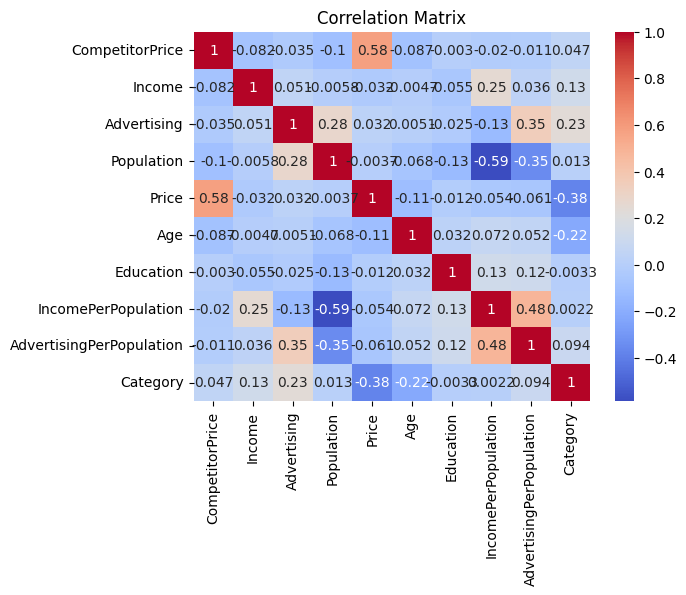

In [253]:
import seaborn as sns

correlation_matrix = train_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [254]:
labelencoder = LabelEncoder()
train_data['Location'] = labelencoder.fit_transform(train_data['Location'])
train_data['Urban'] = labelencoder.fit_transform(train_data['Urban'])
train_data['US'] = labelencoder.fit_transform(train_data['US'])

In [255]:
train_data.head()

,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US,IncomePerPopulation,AdvertisingPerPopulation,Category
0,131,29,11,335,127,0,33,12,1,1,0.086567,0.032836,2
1,148,51,16,148,150,2,58,17,0,1,0.344595,0.108108,2
2,118,71,12,44,89,2,67,18,0,1,1.613636,0.272727,2
3,86,54,0,497,64,0,33,12,1,0,0.108652,0.000000,2
4,113,66,16,322,74,1,76,15,1,1,0.204969,0.049689,3


In [256]:
# Split the data into input features (X) and target variable (y)
X = train_data.drop('Category', axis=1)
y = train_data['Category']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US,IncomePerPopulation,AdvertisingPerPopulation
228,96,39,0,161,112,1,27,14,0,0,0.242236,0.000000
78,116,83,15,170,144,0,71,11,1,1,0.488235,0.088235
90,121,31,0,292,109,2,79,10,1,0,0.106164,0.000000
16,85,79,6,325,95,2,69,13,1,1,0.243077,0.018462
66,133,31,1,80,145,2,42,18,1,1,0.387500,0.012500
...,...,...,...,...,...,...,...,...,...,...,...,...
188,153,68,2,60,133,1,59,16,1,1,1.133333,0.033333
71,98,72,0,59,69,2,65,16,1,0,1.220339,0.000000
106,140,42,0,331,131,0,28,15,1,0,0.126888,0.000000
270,138,73,11,276,120,0,42,17,1,1,0.264493,0.039855


In [257]:
# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [258]:
# Perform hyperparameter tuning
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=10)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [259]:
# Get the best hyperparameters
best_params = grid_search.best_params_
best_params

{'C': 1000}

In [260]:
# Train the logistic regression model with the best hyperparameters
model = LogisticRegression(max_iter=1000, **best_params)
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1000, max_iter=1000)

In [261]:
# Predict on the scaled validation data
val_predictions = model.predict(X_val_scaled)

In [262]:
# Evaluate the model on the validation set
accuracy = (val_predictions == y_val).mean()
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.6142857142857143


In [263]:
# Import the test data
test_data = pd.read_csv('/kaggle/input/car-child-seat-sales-b1/test.csv')
test_data.head()

,ID,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US
0,1,131,21,8,220,171,Good,29,14,Yes,Yes
1,2,118,86,7,265,114,Good,52,15,No,Yes
2,3,129,69,10,289,110,Medium,50,16,No,Yes
3,4,157,53,0,403,124,Bad,58,16,Yes,No
4,5,112,88,2,243,99,Medium,62,11,Yes,Yes


In [264]:
# Drop the first column from the test data
test_data = test_data.iloc[:, 1:]
test_data.head()

,CompetitorPrice,Income,Advertising,Population,Price,Location,Age,Education,Urban,US
0,131,21,8,220,171,Good,29,14,Yes,Yes
1,118,86,7,265,114,Good,52,15,No,Yes
2,129,69,10,289,110,Medium,50,16,No,Yes
3,157,53,0,403,124,Bad,58,16,Yes,No
4,112,88,2,243,99,Medium,62,11,Yes,Yes


In [265]:
# Apply label encoding and scaling to test data
test_data['IncomePerPopulation'] = test_data['Income'] / test_data['Population']
test_data['AdvertisingPerPopulation'] = test_data['Advertising'] / test_data['Population']

In [266]:
labelencoder = LabelEncoder()
test_data['Location'] = labelencoder.fit_transform(test_data['Location'])
test_data['Urban'] = labelencoder.fit_transform(test_data['Urban'])
test_data['US'] = labelencoder.fit_transform(test_data['US'])

In [267]:
# Scale the test data using the same scaler as the training data
test_data_scaled = scaler.transform(test_data)

In [268]:
# Make predictions on the test data
test_predictions = model.predict(test_data_scaled)

In [269]:
# Evaluate the model on the validation set
accuracy = (test_predictions == y[51]).mean()
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.5882352941176471


In [270]:
# Create a submission file
submissions = pd.DataFrame({'ID': test_data.index, 'Category': test_predictions})
submissions['ID'] = submissions.index +1
# Save the submissions DataFrame to a CSV file
submissions.to_csv('submissions.csv', index=False)

In [271]:
submissions.head()

,ID,Category
0,1,1
1,2,2
2,3,2
3,4,2
4,5,2


In [272]:
sub = pd.read_csv('/kaggle/input/car-child-seat-sales-b1/sample_submission.csv')
sub.head()

,ID,Category
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
